<a href="https://colab.research.google.com/github/mattemugno/Smart-Waste-Classifation/blob/main/DepthWise_Separable_Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Depthwise Separable Convolution 

## Introduction

Depthwise Separable Convolution is a convolutional technique used in convolutional neural networks to reduce the number of parameters of the model and improve computational performance.

In this notebook, we will use this technique to train our CNN and compare the results with the previous models we have built. Before that, let us explain what Depthwise Separable Convolution is and why it allows us to achieve better computational performance.

## How it works

While standard convolution performs the channelwise and spatial-wise computation in one step, Depthwise Separable Convolution splits the computation into two steps: depthwise convolution applies a single convolutional filter per each input channel and pointwise convolution is used to create a linear combination of the output of the depthwise convolution.

So, the Depthwise Separable Convolution deals with not only the spatial dimensions but also the depth dimension, which refers to the number of channels in an image. An input image may have 3 channels representing RGB colors, but after passing through a few convolutional layers, it may have multiple channels. Each channel can be thought of as a particular interpretation of the image. For example, the "red" channel interprets the "redness" of each pixel, the "blue" channel interprets the "blueness" of each pixel, and the "green" channel interprets the "greenness" of each pixel. An image with 64 channels has 64 different interpretations of that image.

Below you can see an example of depthwise convolution along one dimension.

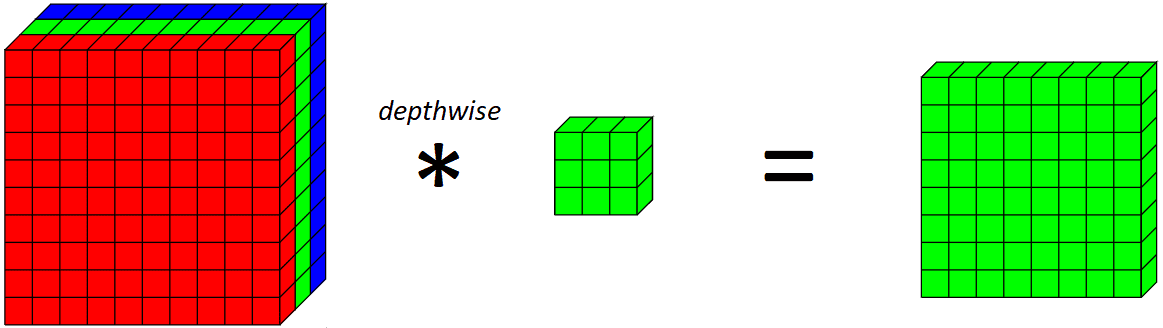

This operation must be applied to all dimensions of the image (e.g., height, width, and depth).
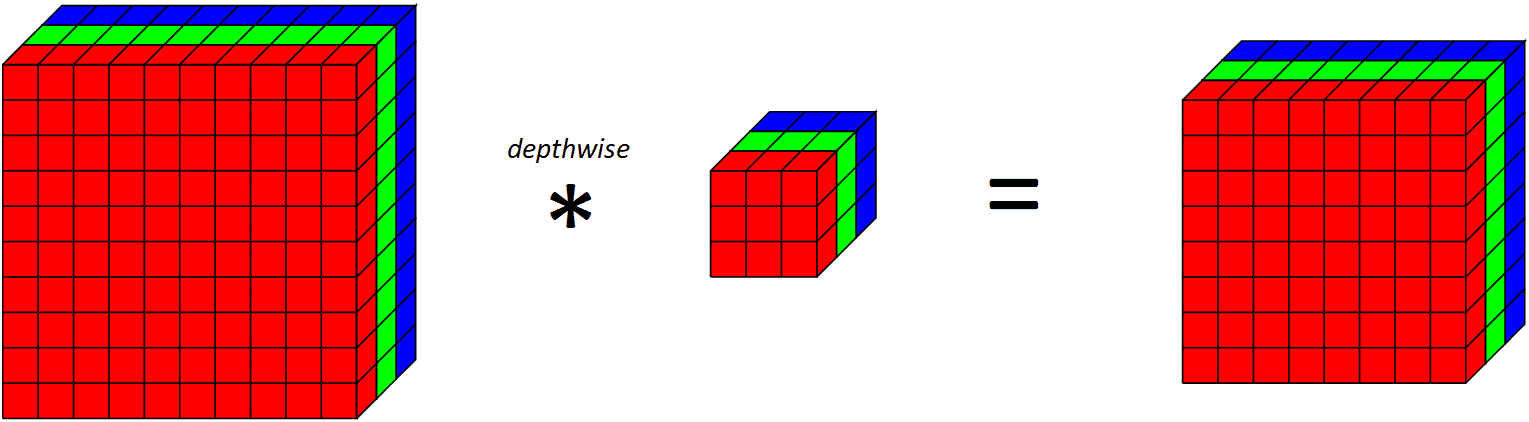

Once the convolution operation has been performed for all dimensions of the image, a pointwise convolution can be performed to aggregate the results into a single output. This involves computing the element-wise sum of the outputs for each channel of the image, resulting in a single output value.

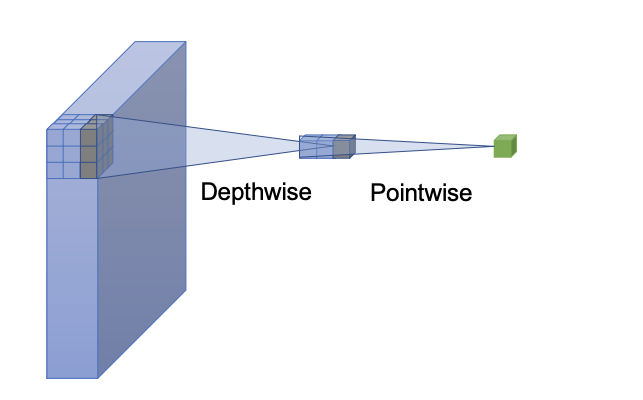

##Why using this technique?

These type of CNN’s are widely used because of the following two reasons –

* They have lesser number of parameters to adjust as compared to the standard CNN’s, which reduces overfitting
* They are computationally cheaper because of fewer computations which makes them suitable for mobile vision applications


#Setup

## Import libraries

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import *
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import datetime

## Unzip preprocessed dataset

In [ ]:
drive.mount('/content/drive/', force_remount=True)
!unzip -q "/content/drive/My Drive/project/SplittedDataset.zip" -d "/content/dataset/"

Mounted at /content/drive/


## Parameters definition


Definition of the paths for each dataset and choice of the size to be used for the images.

In [ ]:
dataset_path = "/content/dataset/content/splitted_dataset"

training_path = os.path.join(dataset_path, "training_set")
validation_path = os.path.join(dataset_path, "validation_set")
test_path = os.path.join(dataset_path, "test_set")

models_path = "/content/models"
if not os.path.exists(models_path):
  os.makedirs(models_path)

Our dataset contains images of various sizes. To ensure consistent inputs for the CNN, we need to resize the images to a standard size. 

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 32
NUM_CLASSES = 8


In the chart above, we can see that the most popular image size in the dataset is 181x181. We therefore decided to set the IMAGE_WIDTH and IMAGE_HEIGHT variables with the most common values.

## Load dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    training_path,
    label_mode='categorical',
    color_mode='rgb',
    shuffle='True',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_path,
    label_mode='categorical',
    color_mode='rgb',
    shuffle='True',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    color_mode='rgb',
    shuffle='False',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 7040 files belonging to 8 classes.
Found 2327 files belonging to 8 classes.
Found 2328 files belonging to 8 classes.


# Utility methods

A function to define the callbacks_list and train the model.

In [ ]:
def compile_and_fit(model, model_name, model_path, learning_rate=None, optimizer='adam'):

  if not os.path.exists(model_path):
    os.makedirs(model_path)

  save_path = os.path.join(model_path, model_name + '.h5')

  if learning_rate is not None:
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=1e-3,
      patience=5,), 
    keras.callbacks.ModelCheckpoint(
      filepath = save_path,
      monitor="val_loss",
      verbose=1,
      save_best_only=True)]

  history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=callbacks_list)    
  plot_accuracy_loss(history)

A function to plot accuracy and loss, both for training set and validation set.

In [ ]:
def plot_accuracy_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  best_loss_epoch = np.argmin(val_loss)
  best_loss = np.min(val_loss)
  best_acc = val_acc[best_loss_epoch]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'bo', label='Validation loss')
  plt.plot(best_loss_epoch, best_loss, 'ro', label='Selected model')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  print(f"Lowest validation loss has been reached at epoch {best_loss_epoch:d} with validation accuracy of {best_acc:.3f}")

A function to evaluate the model against the test set.

In [ ]:
def eval (model):
  y_score = model.predict(test_dataset)
  model.evaluate(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(type(y_true))
  print(type(y_pred))
  print(y_pred.argmax(axis=1))
  print(metrics.classification_report(y_true.numpy().argmax(axis=1),y_pred.argmax(axis=1),digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true.numpy().argmax(axis=1), y_pred.argmax(axis=1))

  # ROC curve
  '''fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()'''

# Implementation 

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
  layers.Rescaling(1./255)
])

## Model definition

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)

x = layers.DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(1, 1), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4, 4))(x)

x = layers.Conv2D(filters=64, padding='same', kernel_size=(3, 3), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(filters=128, padding='same', kernel_size=(3, 3), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 depthwise_conv2d_8 (Depthwi  (None, 224, 224, 3)      30        
 seConv2D)                                                       
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 32)      128       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 28, 28, 64)       0   

Epoch 1/100
220/220 [==============================] - ETA: 0s - loss: 3.1763 - accuracy: 0.2798
Epoch 1: val_loss improved from inf to 1.58319, saving model to /content/models/depthwise_separable_conv/depthwise_separable_conv.h5
220/220 [==============================] - 19s 75ms/step - loss: 3.1763 - accuracy: 0.2798 - val_loss: 1.5832 - val_accuracy: 0.4293
Epoch 2/100
220/220 [==============================] - ETA: 0s - loss: 1.6070 - accuracy: 0.4301
Epoch 2: val_loss improved from 1.58319 to 1.43578, saving model to /content/models/depthwise_separable_conv/depthwise_separable_conv.h5
220/220 [==============================] - 16s 73ms/step - loss: 1.6070 - accuracy: 0.4301 - val_loss: 1.4358 - val_accuracy: 0.4946
Epoch 3/100
219/220 [============================>.] - ETA: 0s - loss: 1.3265 - accuracy: 0.5284
Epoch 3: val_loss did not improve from 1.43578
220/220 [==============================] - 15s 69ms/step - loss: 1.3264 - accuracy: 0.5281 - val_loss: 1.4948 - val_accuracy: 

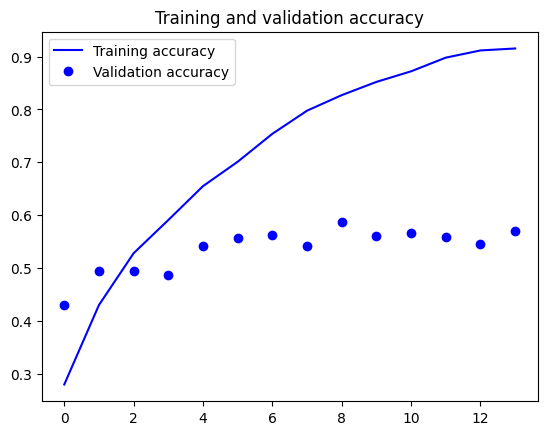

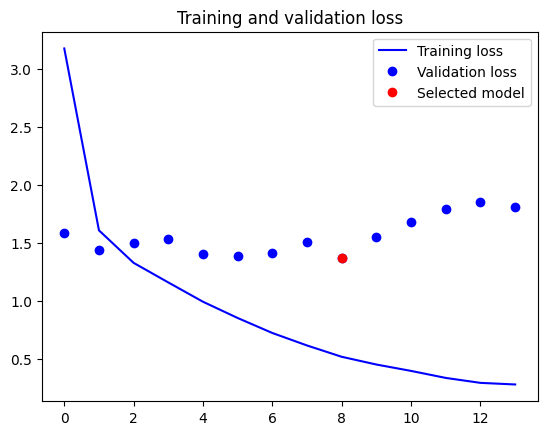

Lowest validation loss has been reached at epoch 8 with validation accuracy of 0.587


In [ ]:
model_name = "depthwise_separable_conv"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

73/73 [==============================] - 3s 40ms/step - loss: 1.3071 - accuracy: 0.6035
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 0 4 ... 4 3 0]
              precision    recall  f1-score   support

           0     0.0635    0.3265    0.1063       147
           1     0.4450    0.3273    0.3772      1112
           2     0.1576    0.0900    0.1145       289
           3     0.0238    0.0102    0.0143        98
           4     0.0994    0.1091    0.1040       165
           5     0.1321    0.0729    0.0940       288
           6     0.0513    0.0458    0.0484       131
           7     0.0333    0.0306    0.0319        98

    accuracy                         0.2092      2328
   macro avg     0.1258    0.1266    0.1113      2328
weighted avg     0.2648    0.2092    0.2248      2328



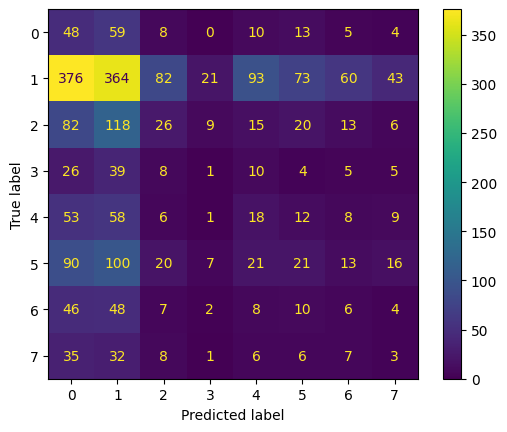

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

#Deeper Network

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = resize_and_rescale(inputs)

x = layers.DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(1, 1), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=4)(x)

x = layers.Conv2D(filters=64, padding='same', kernel_size=(1, 1), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, padding='same', kernel_size=(3, 3), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, padding='same', kernel_size=(3, 3), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 depthwise_conv2d_9 (Depthwi  (None, 224, 224, 3)      30        
 seConv2D)                                                       
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      128       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 56, 56, 64)        2112      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 28, 28, 64)       0   

Epoch 1/100
220/220 [==============================] - ETA: 0s - loss: 2.5375 - accuracy: 0.2997
Epoch 1: val_loss improved from inf to 1.64979, saving model to /content/models/depthwise_separable_conv_deeper/depthwise_separable_conv_deeper.h5
220/220 [==============================] - 23s 86ms/step - loss: 2.5375 - accuracy: 0.2997 - val_loss: 1.6498 - val_accuracy: 0.4250
Epoch 2/100
220/220 [==============================] - ETA: 0s - loss: 1.5946 - accuracy: 0.4311
Epoch 2: val_loss improved from 1.64979 to 1.43302, saving model to /content/models/depthwise_separable_conv_deeper/depthwise_separable_conv_deeper.h5
220/220 [==============================] - 19s 87ms/step - loss: 1.5946 - accuracy: 0.4311 - val_loss: 1.4330 - val_accuracy: 0.5170
Epoch 3/100
220/220 [==============================] - ETA: 0s - loss: 1.4410 - accuracy: 0.4933
Epoch 3: val_loss did not improve from 1.43302
220/220 [==============================] - 21s 93ms/step - loss: 1.4410 - accuracy: 0.4933 - val_l

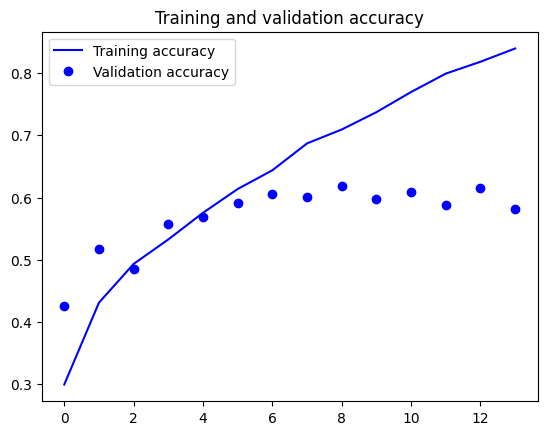

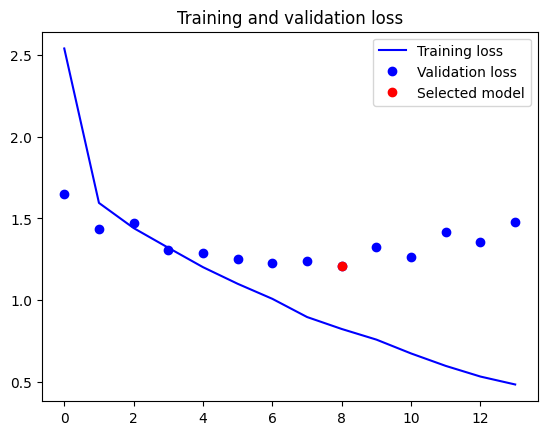

Lowest validation loss has been reached at epoch 8 with validation accuracy of 0.618


In [ ]:
model_name = "depthwise_separable_conv_deeper"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

73/73 [==============================] - 3s 39ms/step - loss: 1.1456 - accuracy: 0.6345
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[0 1 1 ... 5 1 2]
              precision    recall  f1-score   support

           0     0.0690    0.4014    0.1178       147
           1     0.4819    0.3462    0.4029      1112
           2     0.1293    0.0519    0.0741       289
           3     0.0000    0.0000    0.0000        98
           4     0.0718    0.0788    0.0751       165
           5     0.0941    0.0556    0.0699       288
           6     0.0521    0.0382    0.0441       131
           7     0.0510    0.0510    0.0510        98

    accuracy                         0.2139      2328
   macro avg     0.1187    0.1279    0.1044      2328
weighted avg     0.2724    0.2139    0.2277      2328



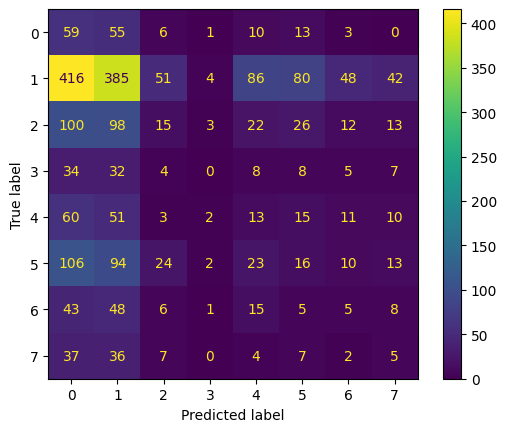

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))

## Considerations

#Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.2), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.1), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

In [ ]:
inputs = keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = data_augmentation(inputs)
x = resize_and_rescale(x)

x = layers.DepthwiseConv2D(kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(1, 1), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(4, 4))(x)

x = layers.Conv2D(filters=64, padding='same', kernel_size=(3, 3), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Conv2D(filters=128, padding='same', kernel_size=(3, 3), strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)

x = layers.Dropout(0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 depthwise_conv2d_10 (Depthw  (None, 224, 224, 3)      30        
 iseConv2D)                                                      
                                                                 
 conv2d_28 (Conv2D)          (None, 224, 224, 32)      128       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 28, 28, 64)       0   

Epoch 1/100
220/220 [==============================] - ETA: 0s - loss: 2.1920 - accuracy: 0.2635
Epoch 1: val_loss improved from inf to 1.74687, saving model to /content/models/depthwise_separable_conv_data_aug/depthwise_separable_conv_data_aug.h5
220/220 [==============================] - 21s 81ms/step - loss: 2.1920 - accuracy: 0.2635 - val_loss: 1.7469 - val_accuracy: 0.3412
Epoch 2/100
220/220 [==============================] - ETA: 0s - loss: 1.7132 - accuracy: 0.3760
Epoch 2: val_loss improved from 1.74687 to 1.53304, saving model to /content/models/depthwise_separable_conv_data_aug/depthwise_separable_conv_data_aug.h5
220/220 [==============================] - 18s 81ms/step - loss: 1.7132 - accuracy: 0.3760 - val_loss: 1.5330 - val_accuracy: 0.4564
Epoch 3/100
220/220 [==============================] - ETA: 0s - loss: 1.5456 - accuracy: 0.4456
Epoch 3: val_loss did not improve from 1.53304
220/220 [==============================] - 20s 88ms/step - loss: 1.5456 - accuracy: 0.4456

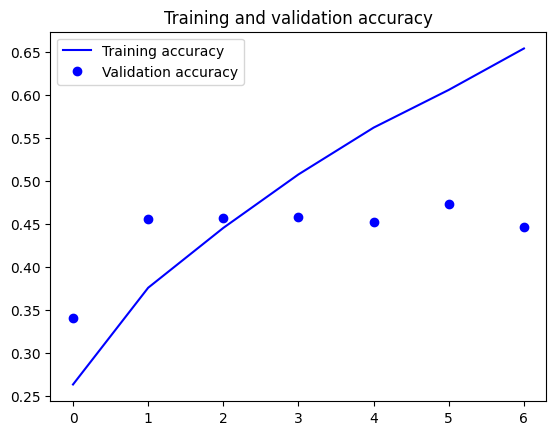

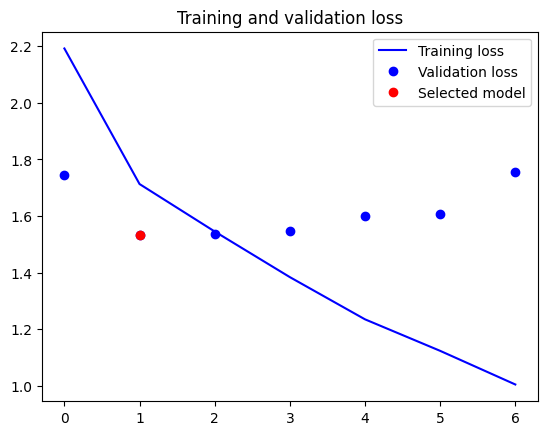

Lowest validation loss has been reached at epoch 1 with validation accuracy of 0.456


In [ ]:
model_name = "depthwise_separable_conv_data_aug"
model_path = os.path.join(models_path, model_name)
compile_and_fit(model, model_name, model_path, learning_rate=0.0001)

73/73 [==============================] - 3s 39ms/step - loss: 1.5103 - accuracy: 0.4759
Classification report: 
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.ndarray'>
[1 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0     0.0621    0.7687    0.1150       147
           1     0.4865    0.1942    0.2776      1112
           2     0.1200    0.0104    0.0191       289
           3     0.0000    0.0000    0.0000        98
           4     0.6667    0.0121    0.0238       165
           5     0.2143    0.0208    0.0380       288
           6     0.0000    0.0000    0.0000       131
           7     0.0000    0.0000    0.0000        98

    accuracy                         0.1460      2328
   macro avg     0.1937    0.1258    0.0592      2328
weighted avg     0.3250    0.1460    0.1486      2328



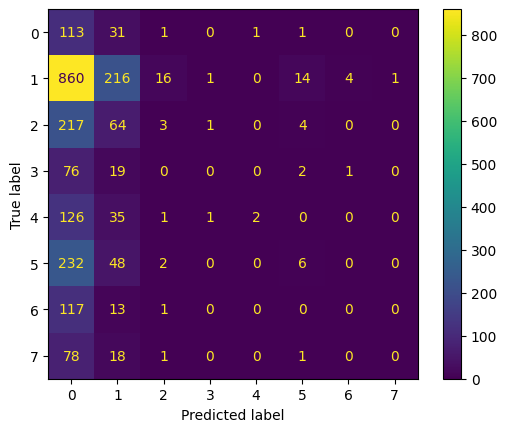

In [ ]:
eval(tf.keras.models.load_model(os.path.join(model_path, model_name + '.h5')))